# Análisis de Datos Exploratorio (EDA)

## Importación de librerias

In [2488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
import re

warnings.filterwarnings('ignore')

from collections import Counter # Para contar frecuencias

## Importar datasets

In [2489]:
df_cast = pd.read_parquet("../Datasets/Datasets_Limpios/Parquet/cast.parquet")
df_crew = pd.read_parquet("../Datasets/Datasets_Limpios/Parquet/crew.parquet")
df_genres = pd.read_parquet("../Datasets/Datasets_Limpios/Parquet/genres.parquet")
df_movies = pd.read_parquet("../Datasets/Datasets_Limpios/Parquet/movies.parquet")
df_prodcompanies = pd.read_parquet("../Datasets/Datasets_Limpios/Parquet/prodcompanies.parquet")
df_prodcountries = pd.read_parquet("../Datasets/Datasets_Limpios/Parquet/prodcountries.parquet")

## Análisis Exploratorio
Para un sistema de recomendación, es importante comprender la diversidad de las películas en términos de géneros, idiomas, popularidad, etc.

## Dataframe 'df_movies'
#### Información relevante del dataset

In [2490]:
df_movies.head(1)

,id,title,genres,overview,tagline,runtime,release_date,production_companies,belongs_to_collection,original_language,spoken_languages,budget,revenue,status,production_countries,popularity,vote_average,vote_count,release_year,return
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",None,81.0,1995-10-30,[3],10194,en,[en],30000000.0,373554033.0,Released,[US],21.946943,7.7,5415.0,1995,12.451801


In [2491]:
df_movies.shape

(45376, 20)

In [2492]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45376 entries, 0 to 45465
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     45376 non-null  int64         
 1   title                  45376 non-null  object        
 2   genres                 45376 non-null  object        
 3   overview               44435 non-null  object        
 4   tagline                20398 non-null  object        
 5   runtime                45130 non-null  float64       
 6   release_date           45376 non-null  datetime64[ns]
 7   production_companies   45376 non-null  object        
 8   belongs_to_collection  4480 non-null   Int64         
 9   original_language      45365 non-null  object        
 10  spoken_languages       45376 non-null  object        
 11  budget                 45376 non-null  float64       
 12  revenue                45376 non-null  float64       
 13  status

#### Revisión de datos faltantes

In [2493]:
df_movies.isnull().sum()

id                           0
title                        0
genres                       0
overview                   941
tagline                  24978
runtime                    246
release_date                 0
production_companies         0
belongs_to_collection    40896
original_language           11
spoken_languages             0
budget                       0
revenue                      0
status                      80
production_countries         0
popularity                   0
vote_average                 0
vote_count                   0
release_year                 0
return                       0
dtype: int64

In [2494]:
# Columnas que contiene
df_movies.columns

Index(['id', 'title', 'genres', 'overview', 'tagline', 'runtime',
       'release_date', 'production_companies', 'belongs_to_collection',
       'original_language', 'spoken_languages', 'budget', 'revenue', 'status',
       'production_countries', 'popularity', 'vote_average', 'vote_count',
       'release_year', 'return'],
      dtype='object')

#### Para continuar con el análisis se eliminarán las columnas que se considera que no aportan valor real.
\
    - tagline: contiene 24978 valores faltantes. \
    \
    - belongs_to_collection: contiene 40896 valores faltantes. \
    \
    - release_date: se considera que al tener la columna 'release_year', ya no es necesaria. \
    \
    - status: un porcentaje extremadamente alto del dataset contiene el mismo dato.

In [2495]:
# Eliminar columnas que no se considerarán
columnas_eliminar = ['tagline', 'release_date', 'status', 'belongs_to_collection']

df_movies_filtered = df_movies.drop(columns=columnas_eliminar)

df_movies_filtered.head(2)

,id,title,genres,overview,runtime,production_companies,original_language,spoken_languages,budget,revenue,production_countries,popularity,vote_average,vote_count,release_year,return
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],en,[en],30000000.0,373554033.0,[US],21.946943,7.7,5415.0,1995,12.451801
1,8844,Jumanji,"[12, 14, 10751]",When siblings Judy and Peter discover an encha...,104.0,"[559, 2550, 10201]",en,"[en, fr]",65000000.0,262797249.0,[US],17.015539,6.9,2413.0,1995,4.043035


In [2496]:
df_movies_filtered.isnull().sum()

id                        0
title                     0
genres                    0
overview                941
runtime                 246
production_companies      0
original_language        11
spoken_languages          0
budget                    0
revenue                   0
production_countries      0
popularity                0
vote_average              0
vote_count                0
release_year              0
return                    0
dtype: int64

Se eliminarán todos aquellos títulos que no son correspondientes a idiomas con caracteres latinos

In [2497]:
# Crear una expresión regular que busque caracteres latinos
regex_latin = re.compile(r'[a-zA-Z]')

# Filtrar las filas que NO contienen ningún carácter latino
df_movies_filtered = df_movies_filtered[df_movies_filtered['title'].apply(lambda x: bool(regex_latin.search(x)))]

#### Revisión de duplicados

Se buscan duplicados en cada columna

#### Columna 'id'

In [2498]:
# Obtener las filas que tienen duplicados en la columna 'id'
duplicados = df_movies_filtered[df_movies_filtered.duplicated(subset=['id'], keep=False)].sort_values('id')

# Eliminar duplicados
df_movies_filtered.drop_duplicates(subset='id', inplace=True)

In [2499]:
duplicados = df_movies_filtered[df_movies_filtered.duplicated(subset=['id'], keep=False)].sort_values('id')
duplicados.head(2)

,id,title,genres,overview,runtime,production_companies,original_language,spoken_languages,budget,revenue,production_countries,popularity,vote_average,vote_count,release_year,return


### Normalización de columnas referentes a dinero (Budget, Revenue)


In [2500]:
df_movies_filtered['budget'] = df_movies_filtered['budget']/1000000
df_movies_filtered['revenue'] = df_movies_filtered['revenue']/1000000
df_movies_filtered['return'] = df_movies_filtered['return']/1000000

Información del Dataset

In [2501]:
df_movies_filtered[['runtime', 'budget', 'revenue', 'return', 'popularity', 'vote_average']].describe()

,runtime,budget,revenue,return,popularity,vote_average
count,44997.000000,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,94.178923,4.230001,11.225395,0.000662,2.925395,5.624700
std,38.295656,17.435722,64.363783,0.074820,6.013103,1.913972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,85.000000,0.000000,0.000000,0.000000,0.389606,5.000000
50%,95.000000,0.000000,0.000000,0.000000,1.131039,6.000000
75%,107.000000,0.000000,0.000000,0.000000,3.685072,6.800000
max,1256.000000,380.000000,2787.965087,12.396383,547.488298,10.000000


### Distribución de duración de las películas
Visualizar cómo se distribuyen las películas en su duración

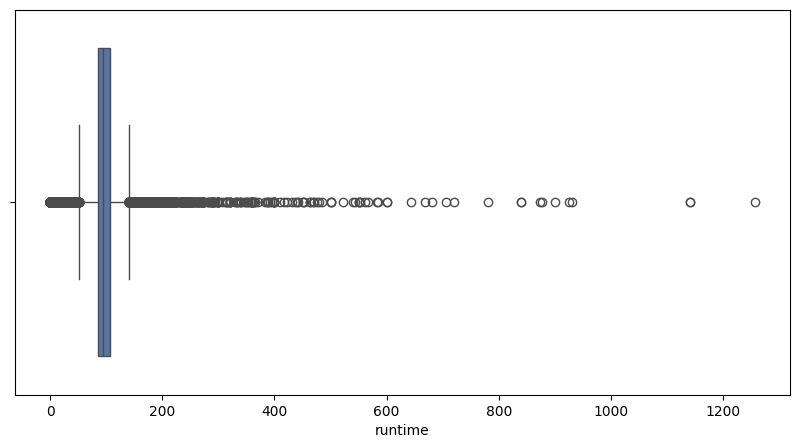

In [2502]:
# Boxplot para ver la distribución según la duración de las películas
plt.figure(figsize=(10, 5))
sns.boxplot(data = df_movies_filtered, x = 'runtime', palette='deep')
plt.show()

Existe gran número de outliers para esta columna

In [2503]:
# Filtrar las filas donde 'runtime' es mayor que 210 - es decir, 3 horas y 30 minutos
outliers = df_movies_filtered[df_movies_filtered['runtime'] > 210]

# Mostrar la cantidad de ocurrencias por valor único de 'runtime'
outliers_count = outliers['runtime'].count()
print(outliers_count)

286


Es necesario analizar las características de estos outliers, y ver similitudes entre ellos

In [2504]:
# Eliminación de nulos
outliers.isnull().sum()

# Solamente la columna 'overview' tiene nulos (2)
outliers.dropna(subset=['overview'], inplace=True)

In [2505]:
# Lista vacía para almacenar los géneros
lista_generos_outliers = []

# Iterar sobre las listas de géneros dentro de outliers
for index, row in outliers.iterrows():
    generos = row['genres']
    lista_generos_outliers.extend(generos)

# Contar la frecuencia de géneros
conteo_generos = Counter(lista_generos_outliers)

conteo_generos_nombre = {}

# Iterar sobre las claves (item_ids) y valores del diccionario
for item_id, count in conteo_generos.items():
    # Buscar el nombre del género correspondiente al item_id
    genero_nombre = df_genres.loc[df_genres['id'] == item_id, 'name'].values[0]
    
    # Asignar el nuevo nombre del género como clave en el nuevo diccionario
    conteo_generos_nombre[genero_nombre] = count

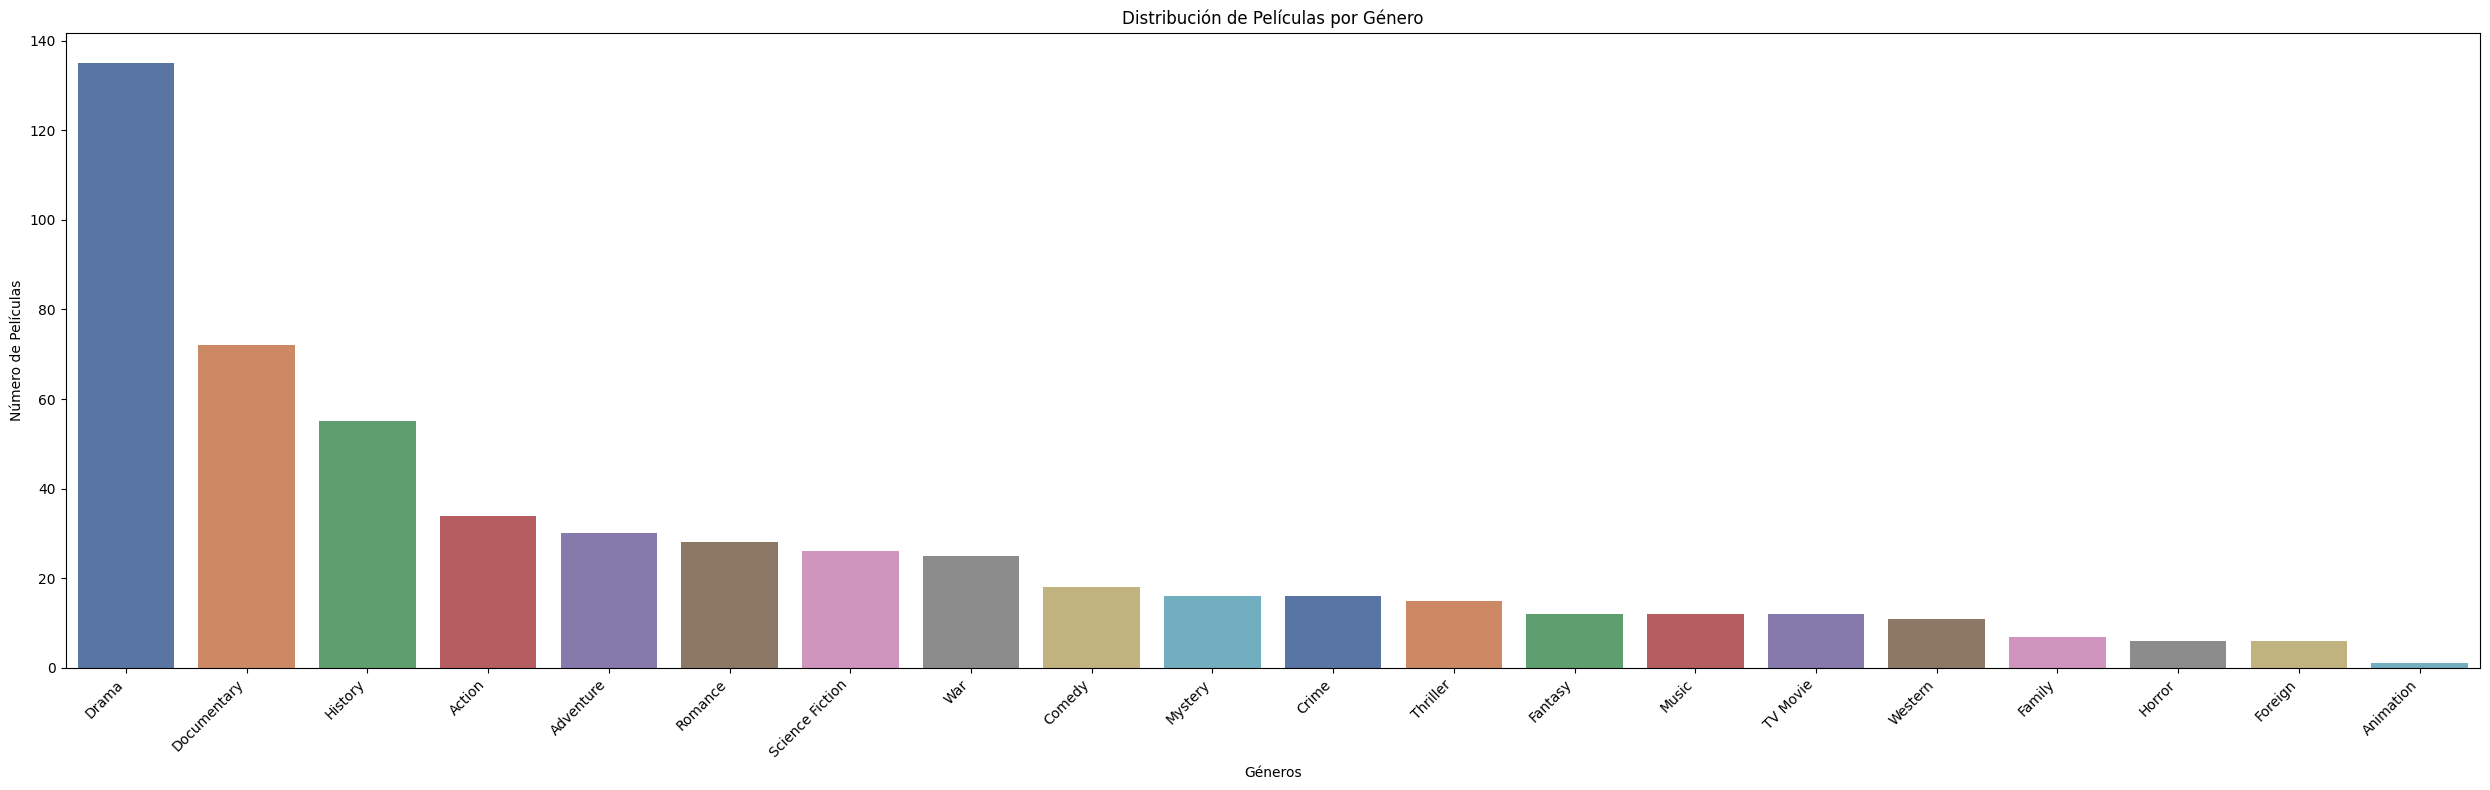

In [2506]:
# Crear listas para ploteo
generos = list(conteo_generos_nombre.keys())
conteo = list(conteo_generos_nombre.values())

# Crear un DataFrame a partir de los géneros y sus conteos
df_generos = pd.DataFrame({'Género': generos, 'Conteo': conteo})

# Ordenar el DataFrame por el conteo en orden descendente
df_generos = df_generos.sort_values(by='Conteo', ascending=False)

# Histograma para ver la distribución
plt.figure(figsize=(25, 8))
sns.barplot(x='Género', y='Conteo', data=df_generos, palette='deep')
plt.title('Distribución de Películas por Género')
plt.xlabel('Géneros')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

La mayor cantidad de outliers, pertencen al género de drama

Se analizarán las características numéricas de los outliers

In [2507]:
# Ver cuántas películas tienen duraciones mayores a 180 minutos (3 horas)
outliers = df_movies_filtered[df_movies_filtered['runtime'] > 210]

# Revisar el número de outliers
print("Número de películas con duraciones mayores a 3 horas y 30 minutos:", outliers.shape[0])

# Revisar otras características importantes de estas películas
outliers[['title', 'popularity', 'vote_average', 'budget', 'revenue']].describe()

Número de películas con duraciones mayores a 3 horas y 30 minutos: 286


,popularity,vote_average,budget,revenue
count,286.000000,286.000000,286.000000,286.000000
mean,2.039573,6.542308,2.957506,3.191456
std,3.143220,2.179424,13.640188,26.888358
min,0.000308,0.000000,0.000000,0.000000
25%,0.407850,6.025000,0.000000,0.000000
50%,0.980089,7.000000,0.000000,0.000000
75%,2.252280,7.900000,0.000000,0.000000
max,32.182851,10.000000,125.000000,400.176459


En el análisis exploratorio, se identificaron 280 películas con una duración superior a 3 horas y 30 minutos, representando aproximadamente el 1% del total de películas. Si bien estas películas tienen una calificación promedio alta (6.53), su popularidad media es moderada (2.06).

Dado que estas películas representan un grupo reducido y contienen valores atípicos en cuanto a duración, se decidió eliminarlas del análisis. Esta decisión permitirá centrarse en películas con una estructura narrativa más convencional y con datos más consistentes, sin distorsionar los resultados de popularidad y calificaciones generales del conjunto de datos.

Eliminar todas las películas con una duración mayor a 3 horas y 30 minutos

In [2508]:
df_movies_filtered = df_movies_filtered[df_movies_filtered['runtime'] < 210]

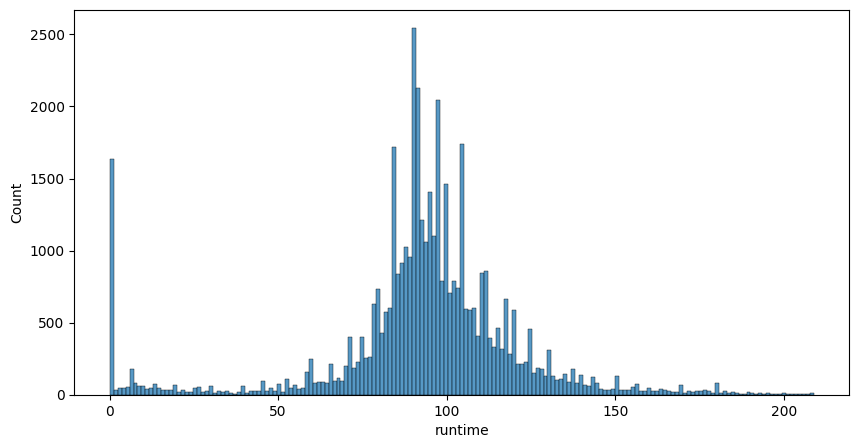

In [2509]:
# Histograma para ver la distribución según la duración de las películas
plt.figure(figsize=(10, 5))
sns.histplot(data = df_movies_filtered, x = 'runtime', palette='deep')
plt.show()

Se eliminarán las películas que no tengan un dato real de duración

In [2510]:
df_movies_filtered = df_movies_filtered[df_movies_filtered['runtime'] > 0]

### Distribución de presupuesto de las películas
Visualizar cómo se distribuyen las películas en su presupuesto

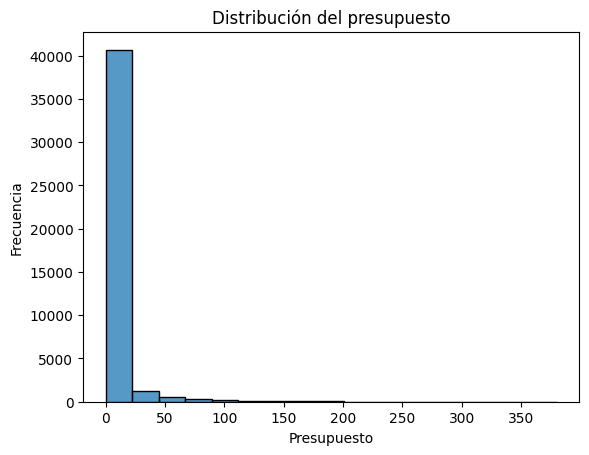

In [2511]:
# Histograma del presupuesto
sns.histplot(data=df_movies_filtered, x='budget')
plt.title('Distribución del presupuesto')
plt.xlabel('Presupuesto')
plt.ylabel('Frecuencia')
plt.show()

Cerca del 100% de los datos de presupuesto son faltantes. Este alto nivel de valores faltantes y erróneos compromete la integridad de cualquier análisis basado en dichas columnas, ya que imputar los valores faltantes o intentar categorizarlos habría introducido un sesgo o distorsión significativa en los resultados.

In [2512]:
df_movies_filtered.drop(columns='budget', inplace=True)
df_movies_filtered.head(1)

,id,title,genres,overview,runtime,production_companies,original_language,spoken_languages,revenue,production_countries,popularity,vote_average,vote_count,release_year,return
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],en,[en],373.554033,[US],21.946943,7.7,5415.0,1995,0.000012


### Distribución de ganacias de las películas
Visualizar cómo se distribuyen las películas según sus ganancias

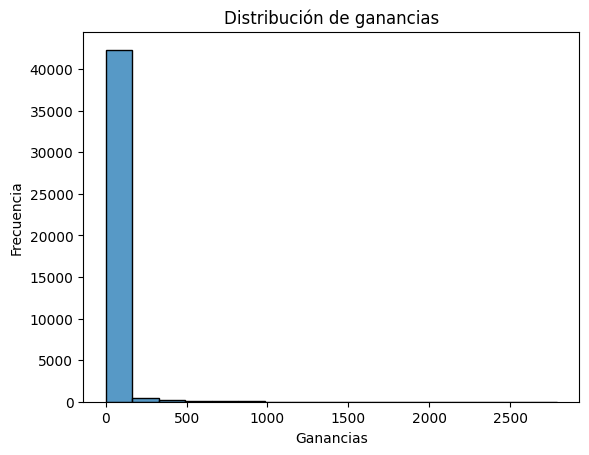

In [2513]:
# Histograma de las ganancias
sns.histplot(data=df_movies_filtered, x='revenue')
plt.title('Distribución de ganancias')
plt.xlabel('Ganancias')
plt.ylabel('Frecuencia')
plt.show()

Cerca del 100% de los datos de ganancias son faltantes. Este alto nivel de valores faltantes y erróneos compromete la integridad de cualquier análisis basado en dichas columnas, ya que imputar los valores faltantes o intentar categorizarlos habría introducido un sesgo o distorsión significativa en los resultados.

In [2514]:
df_movies_filtered.drop(columns='revenue', inplace=True)
df_movies_filtered.head(2)

,id,title,genres,overview,runtime,production_companies,original_language,spoken_languages,production_countries,popularity,vote_average,vote_count,release_year,return
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],en,[en],[US],21.946943,7.7,5415.0,1995,0.000012
1,8844,Jumanji,"[12, 14, 10751]",When siblings Judy and Peter discover an encha...,104.0,"[559, 2550, 10201]",en,"[en, fr]",[US],17.015539,6.9,2413.0,1995,0.000004


Ya que se eliminaron las variables financieras, la columna 'return' ya no es necesaria

In [2515]:
df_movies_filtered.drop(columns='return', inplace=True)

### Distribución de Géneros
Los géneros juegan un papel importante en las recomendaciones, ya que son características clave para la similitud de las películas.

In [2516]:
# Rellenar las listas vacías con 0
df_movies_filtered['genres'] = df_movies_filtered['genres'].apply(lambda x: [0] if len(x) == 0 else x)

In [2517]:
df_genres.head()

,id,name
0,0,No Data
1,12,Adventure
2,14,Fantasy
3,16,Animation
4,18,Drama


In [2518]:
# Crear un diccionario para mapear IDs a nombres de géneros
generos_dict = dict(zip(df_genres['id'], df_genres['name']))

# Lista vacía para almacenar los géneros por nombre
lista_generos_nombre = []

# Añadir todos los géneros a la lista (IDs)
for genero_nombre in df_movies_filtered['genres']:
    lista_generos_nombre.extend(genero_nombre)

# Convertir los IDs a nombres usando el diccionario
for i, item in enumerate(lista_generos_nombre):
    if item in generos_dict:  # Verificar si el ID existe en el diccionario
        lista_generos_nombre[i] = generos_dict[item]

# Contar la frecuencia de los géneros
conteo_generos_nombre = Counter(lista_generos_nombre)

# Imprimimos el resultado
print(conteo_generos_nombre)

Counter({'Drama': 19608, 'Comedy': 12640, 'Thriller': 7417, 'Romance': 6564, 'Action': 6410, 'Horror': 4577, 'Crime': 4202, 'Documentary': 3692, 'Adventure': 3388, 'Science Fiction': 2945, 'Family': 2690, 'Mystery': 2400, 'Fantasy': 2252, 'Animation': 1896, 'No Data': 1836, 'Music': 1554, 'Foreign': 1545, 'History': 1307, 'War': 1271, 'Western': 1017, 'TV Movie': 713})


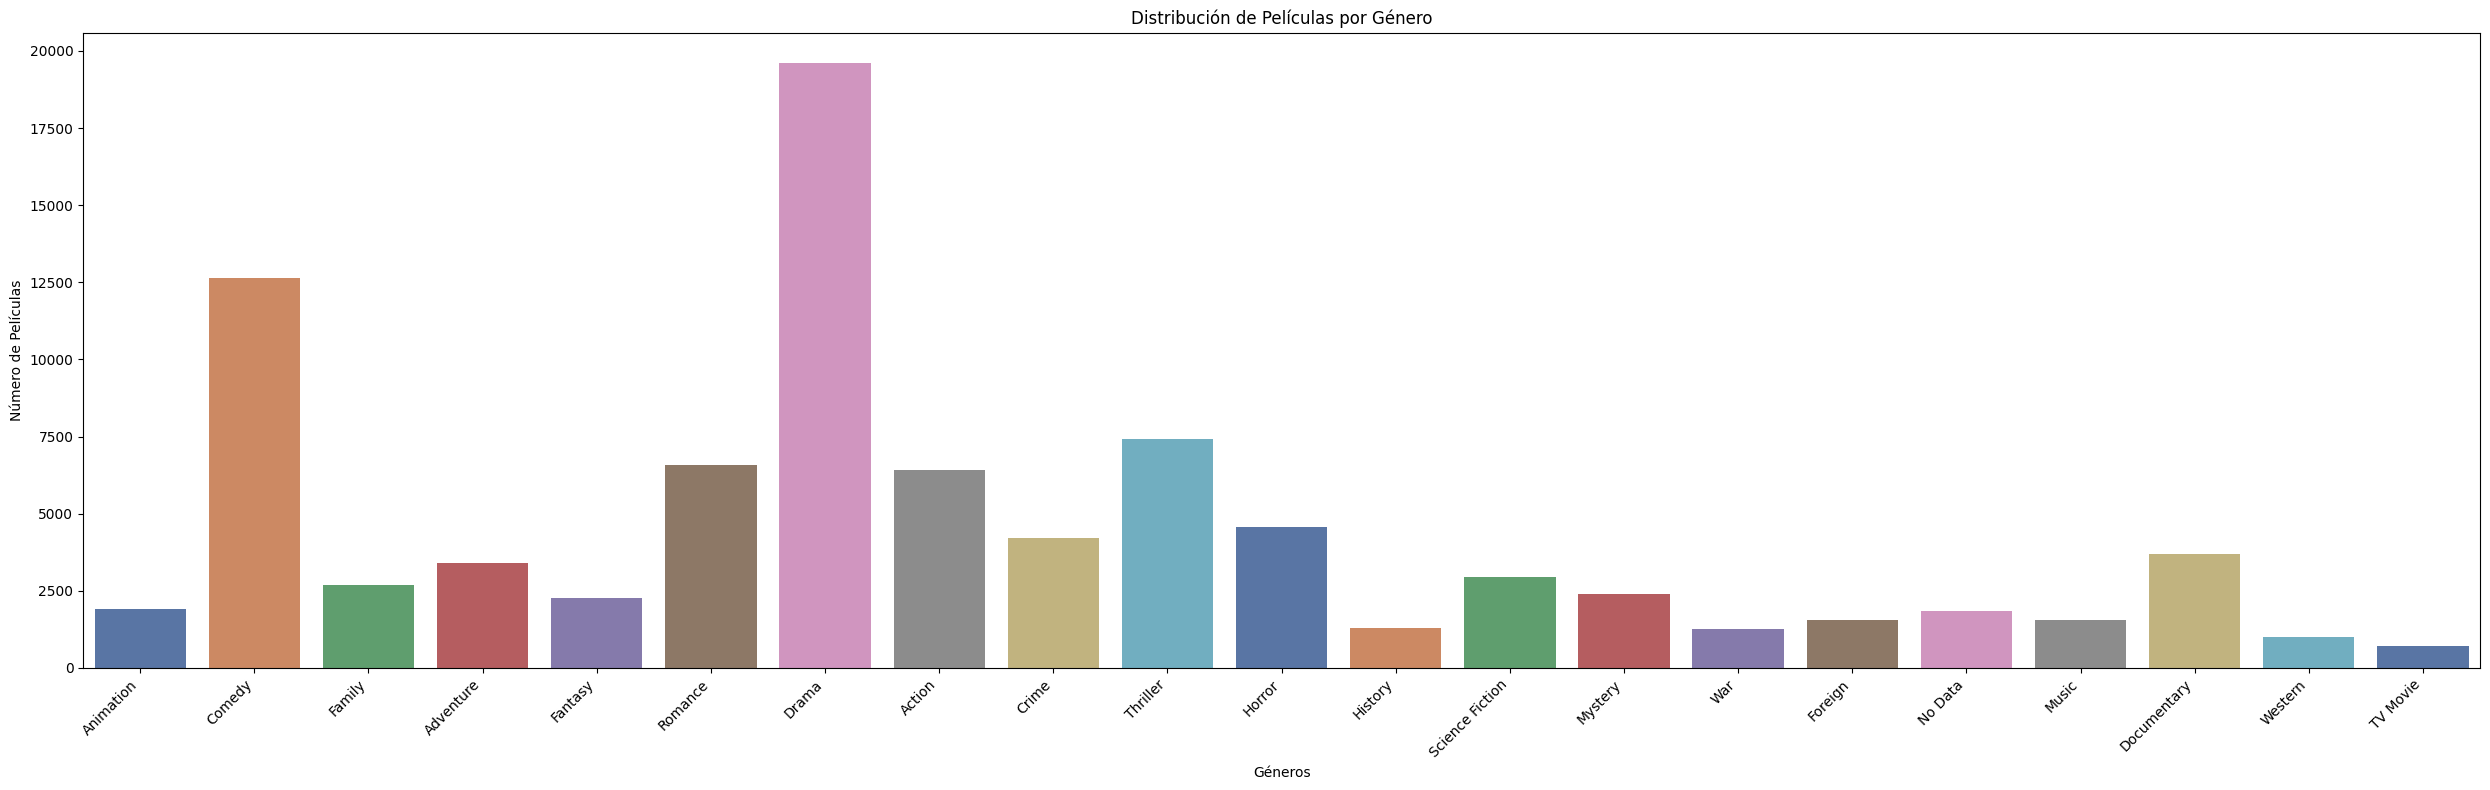

In [2519]:
# Crear listas para ploteo
generos = list(conteo_generos_nombre.keys())
conteo = list(conteo_generos_nombre.values())

# Histograma para ver la distribución
plt.figure(figsize=(25, 8))
sns.barplot(x = generos, y = conteo, palette='deep')
plt.title('Distribución de Películas por Género')
plt.xlabel('Géneros')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Se eliminarán las películas sin un dato real de género

In [2520]:
# Filtrar las filas donde el valor de la columna 'genres' no sea [0]
df_movies_filtered = df_movies_filtered[df_movies_filtered['genres'].apply(lambda x: not np.array_equal(x, [0]))]

### Distribución de años de lanzamiento
Visualizar cómo se distribuyen las películas a lo largo de los años

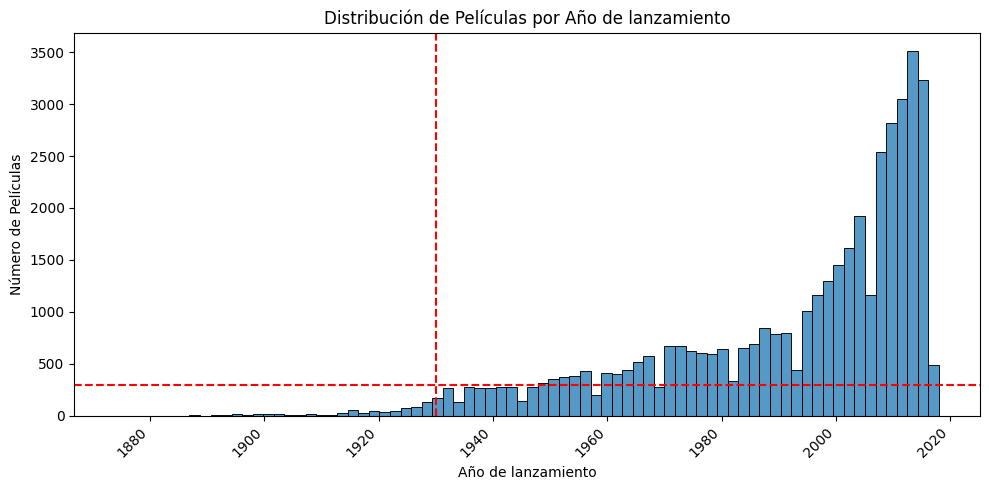

In [2521]:
# Histograma para ver la distribución según los años de lanzamiento
plt.figure(figsize=(10, 5))
sns.histplot(data = df_movies_filtered, x = 'release_year', palette='deep')
plt.title('Distribución de Películas por Año de lanzamiento')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Número de Películas')
plt.axhline(y=300, color='red', linestyle='--')
plt.axvline(x=1930, color='red', linestyle='--') 
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Como resultado del análisis de esta distribución, se tomarán las películas lanzadas a partir del año 1930, siendo 300 el número más constante en el inicio de la tendencia hacia arriba

In [2522]:
df_movies_filtered = df_movies_filtered[df_movies_filtered['release_year'] >= 1930]

### Distribución de idioma de las películas
Visualizar cómo se distribuyen las películas en su idioma original

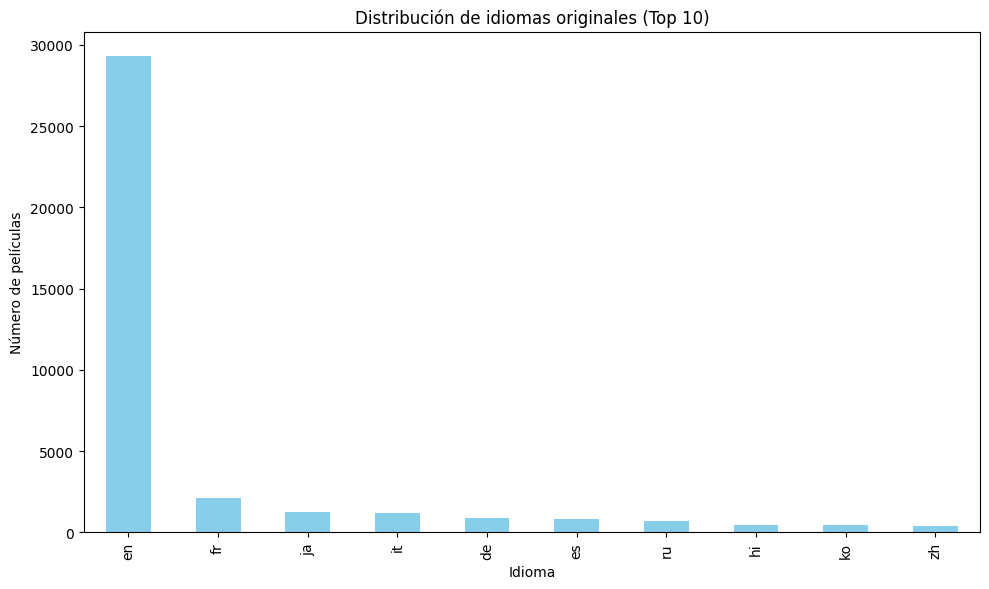

In [2523]:
# Obtener los top 10 idiomas originales
top10_languages = df_movies_filtered['original_language'].value_counts().head(10)

# Crear el gráfico de barras para los top 10
top10_languages.plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title('Distribución de idiomas originales (Top 10)')
plt.xlabel('Idioma')
plt.ylabel('Número de películas')
plt.tight_layout()
plt.show()

Debido a la distribución de los datos, se decide crear dos categorías de idiomas: English y Other Languages

In [2524]:
df_movies_filtered['original_language'] = df_movies_filtered['original_language'].apply(lambda x: 'English' if x == 'en' else 'Other Languages')

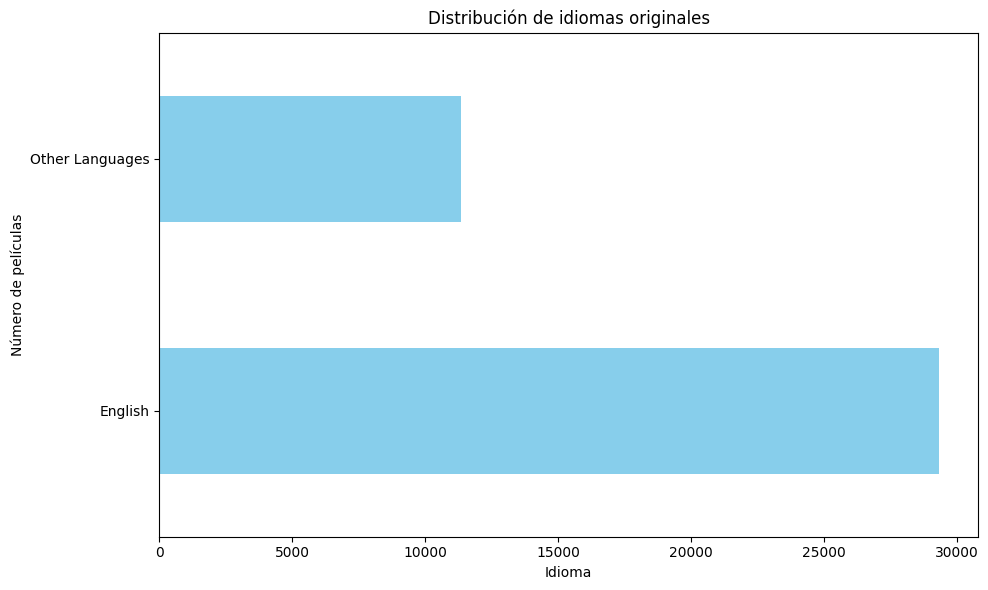

In [2525]:
# Contar la frecuencia de cada idioma en 'original_language'
language_counts = df_movies_filtered['original_language'].value_counts()

# Crear el gráfico de barras
language_counts.plot(kind='barh', figsize=(10,6), color='skyblue')

# Añadir título y etiquetas
plt.title('Distribución de idiomas originales')
plt.xlabel('Idioma')
plt.ylabel('Número de películas')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

De acuerdo a la distribución donde existe una clara superioridad del idioma inglés, se considera que la columna original_language, no aporta valor real al análisis

In [2526]:
df_movies_filtered.drop(columns='original_language', inplace=True)

In [2527]:
df_movies_filtered.head(1)

,id,title,genres,overview,runtime,production_companies,spoken_languages,production_countries,popularity,vote_average,vote_count,release_year
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],[en],[US],21.946943,7.7,5415.0,1995


### Distribución de países de producción de las películas
Visualizar cómo se distribuyen las películas según los paises en los que se produjeron

In [2528]:
df_final = (
    df_movies_filtered[['production_countries']]
    .explode('production_countries')  # Descomponer la columna de listas
    .reset_index(drop=True)  # Restablecer el índice
)

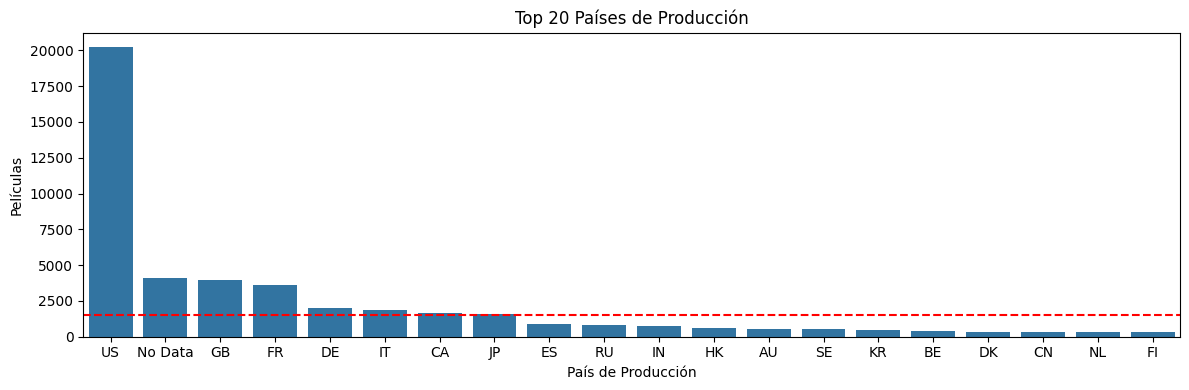

In [2529]:
# Calcular la frencuencia de los países de producción
top20_prodcountries = df_final['production_countries'].value_counts().head(20)

plt.figure(figsize=(12,4))
sns.barplot(data=top20_prodcountries)
plt.xlabel('País de Producción')
plt.ylabel('Películas')
plt.title('Top 20 Países de Producción')
plt.axhline(y=1500, color='red', linestyle='--')
plt.tight_layout()
plt.show()

Se eliminarán los datos que no tengan un dato real de país de producción

In [2530]:
df_movies_filtered = df_movies_filtered[df_movies_filtered['production_countries'].apply(lambda x: not np.array_equal(x, ['No Data']))]

Debido a la distribución vista, la columna 'production_countries' se dividirá en dos grupos: US, Other_Countries

In [2531]:
df_movies_filtered['production_countries'] = df_movies_filtered['production_countries'].apply(
    lambda x: ['US' if country == 'US' else 'Other_Countries' for country in x]
)

Eliminar valores duplicados de Other_Countries

In [2532]:
# Función para eliminar valores duplicados de 'Other_Countries'
def remove_duplicates(countries):
    if isinstance(countries, list):
        # Convertir la lista a un conjunto para eliminar duplicados, y volver a lista
        return list(dict.fromkeys(countries))
    return countries

# Aplicar la función a la columna 'production_countries'
df_movies_filtered['production_countries'] = df_movies_filtered['production_countries'].apply(remove_duplicates)


In [2533]:
df_movies_filtered.head(1)

,id,title,genres,overview,runtime,production_companies,spoken_languages,production_countries,popularity,vote_average,vote_count,release_year
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],[en],[US],21.946943,7.7,5415.0,1995


### Distribución de lenguajes hablados de las películas
Visualizar cómo se distribuyen las películas según sus idiomas disponibles

In [2534]:
df_final = (
    df_movies_filtered[['spoken_languages']]
    .explode('spoken_languages')  # Descomponer la columna de listas
    .reset_index(drop=True)  # Restablecer el índice
)

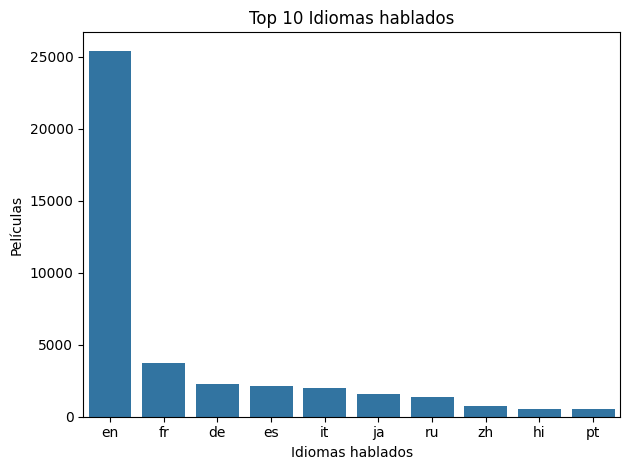

In [2535]:
spoken_languages_counts = df_final['spoken_languages'].value_counts()

# Filtrar los idiomas que tienen más de 400 apariciones
top10_lang = spoken_languages_counts[spoken_languages_counts > 400].head(10)

sns.barplot(data=top10_lang)
plt.xlabel('Idiomas hablados')
plt.ylabel('Películas')
plt.title('Top 10 Idiomas hablados')
plt.tight_layout()
plt.show()

Debido a la distribución vista, la columna 'spoken_languages' se dividirá en tres grupos: English, Other_Languages y No Data

In [2536]:
# Convertir el valor de 'spoken_languages' a una lista de valores únicos, mapeando 'en' a 'English', '' a 'No Data' y cualquier otro valor a 'Other_Languages'
df_movies_filtered['spoken_languages'] = df_movies_filtered['spoken_languages'].apply(
    lambda x: list(dict.fromkeys(
        ['English' if language == 'en' else 'No Data' if language == '' else 'Other_Languages' 
         for language in (x.tolist() if isinstance(x, np.ndarray) else (x if isinstance(x, list) else []))]
    ))
)

In [2537]:
# Inicializar una lista vacía para almacenar los IDs de las filas donde 'spoken_languages' es una lista vacía
id_lista = []

# Iterar sobre cada fila del DataFrame para verificar si 'spoken_languages' es una lista vacía
for index, row in df_movies_filtered.iterrows():
    # Verificar si 'spoken_languages' es una lista
    if isinstance(row['spoken_languages'], list):
        item = row['spoken_languages']
        id_item = row['id']
        # Verificar si la lista está vacía
        if len(item) > 0:
            pass
        else:
            id_lista.append(id_item)
    else:
        # Imprimir el ID de la fila si 'spoken_languages' no es una lista
        id = row['id']
        print(f'${id} no es una lista')
        
# Reemplazar el valor de 'spoken_languages' por ['No Data'] para las filas cuyos IDs están en 'id_lista'
df_movies_filtered.loc[df_movies_filtered['id'].isin(id_lista), 'spoken_languages'] = [['No Data']] * df_movies_filtered.loc[df_movies_filtered['id'].isin(id_lista)].shape[0]

Se eliminarán los datos que no tengan un dato real de lenguaje hablado

In [2538]:
df_movies_filtered = df_movies_filtered[df_movies_filtered['spoken_languages'] != 'No Data']

### Distribución de popularidad de las películas
Visualizar cómo se distribuyen las películas según su popularidad

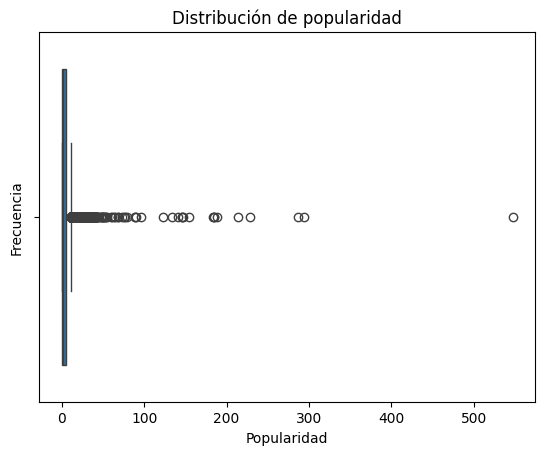

In [2539]:
# Boxplot de las películas según su popularidad
sns.boxplot(data=df_movies_filtered, x='popularity')
plt.title('Distribución de popularidad')
plt.xlabel('Popularidad')
plt.ylabel('Frecuencia')
plt.show()

### Distribución de puntaje promedio de las películas
Visualizar cómo se distribuyen las películas según su puntaje promedio

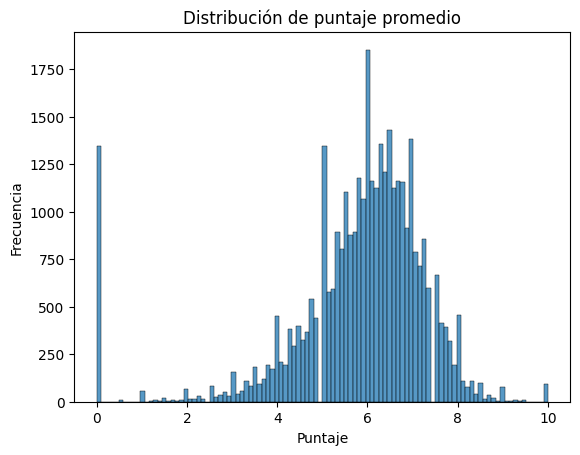

In [2540]:
# Histograma de puntaje promedio
sns.histplot(data=df_movies_filtered, x='vote_average')
plt.title('Distribución de puntaje promedio')
plt.xlabel('Puntaje')
plt.ylabel('Frecuencia')
plt.show()

Se eliminarán las películas sin un dato real de puntaje promedio

In [2541]:
# Filtrar las filas donde 'vote_average' no sea 0 y tampoco sea nulo
df_movies_filtered = df_movies_filtered[df_movies_filtered['vote_average'].apply(lambda x: not np.array_equal(x, 0) if x is not None else False)]

### Relación Película - Popularidad
Se quiere analizar cuales compañías películas tienen mayor popularidad dentro del dataset

In [2542]:
df_final = (
    df_movies_filtered[['title', 'popularity']]
    .sort_values(by='popularity', ascending=False)
    .reset_index(drop=True)
)

df_final.head(10)

,title,popularity
0,Minions,547.488298
1,Wonder Woman,294.337037
2,Beauty and the Beast,287.253654
3,Baby Driver,228.032744
4,Big Hero 6,213.849907
5,Deadpool,187.860492
6,Guardians of the Galaxy Vol. 2,185.330992
7,Avatar,185.070892
8,John Wick,183.870374
9,Gone Girl,154.801009


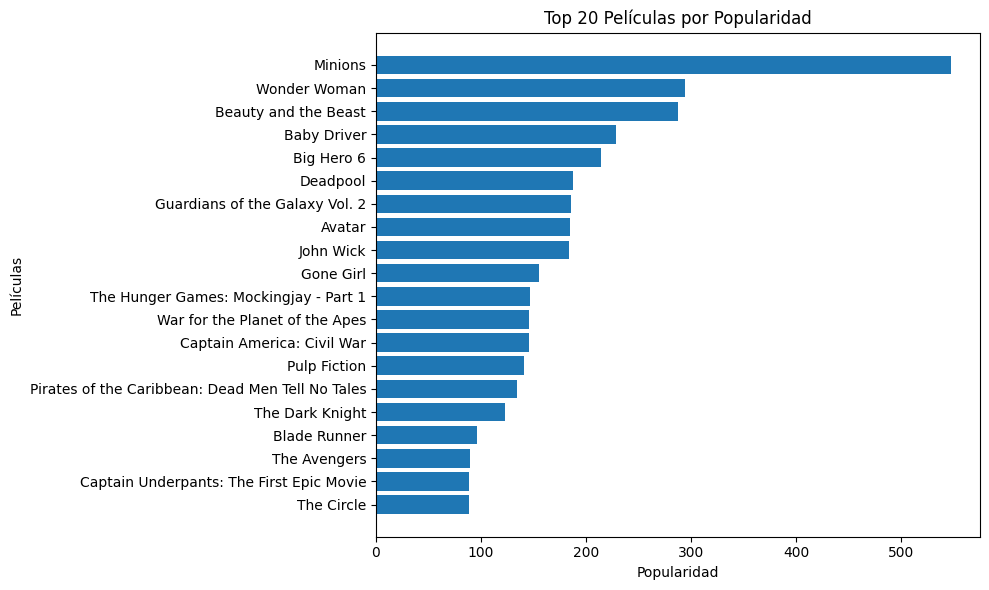

In [2543]:
# Seleccionar las primeras 20 películas según popularidad
top_20_pelis = df_final.head(20)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_20_pelis['title'], top_20_pelis['popularity'])
plt.xlabel('Popularidad')
plt.ylabel('Películas')
plt.title('Top 20 Películas por Popularidad')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Relación Película - Votación promedio
Se quiere analizar la distribución de calidad en cuanto a votación promedio en el dataset

In [2544]:
df_final = (
    df_movies_filtered[['title', 'vote_average']]
    .sort_values(by='vote_average', ascending=False)
    .reset_index(drop=True)
)

Para analizar de forma balanceada la cantidad de votos con el rating obtenido en el promedio de la votación se utilizará una técnica comúnmente conocida como **Weighted Rating (Calificación Ponderada)**.\
\
Esta técnica se utiliza en muchos sistemas de recomendación para ajustar el rating de una película según el número de votos que ha recibido, evitando que películas con muy pocos votos tengan una calificación extremadamente alta o baja que no sea representativa.

In [2545]:
# Calcular el promedio global de todas las calificaciones (C)
C = df_movies_filtered['vote_average'].mean()

# Definir el número mínimo de votos requeridos (m)
m = df_movies_filtered['vote_count'].quantile(0.80)  # 80% superior de las películas

# Calcular el Weighted Rating para cada película
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    weighted_score = (v / (v + m) * R) + (m / (v + m) * C)
    return round(weighted_score, 2)

df_movies_filtered['weighted_rating'] = df_movies_filtered.apply(weighted_rating, axis=1)

# Mostrar el DataFrame con el rating ponderado
df_weighted_rating = df_movies_filtered[['title', 'vote_count', 'vote_average', 'weighted_rating']].sort_values('weighted_rating', ascending=False)

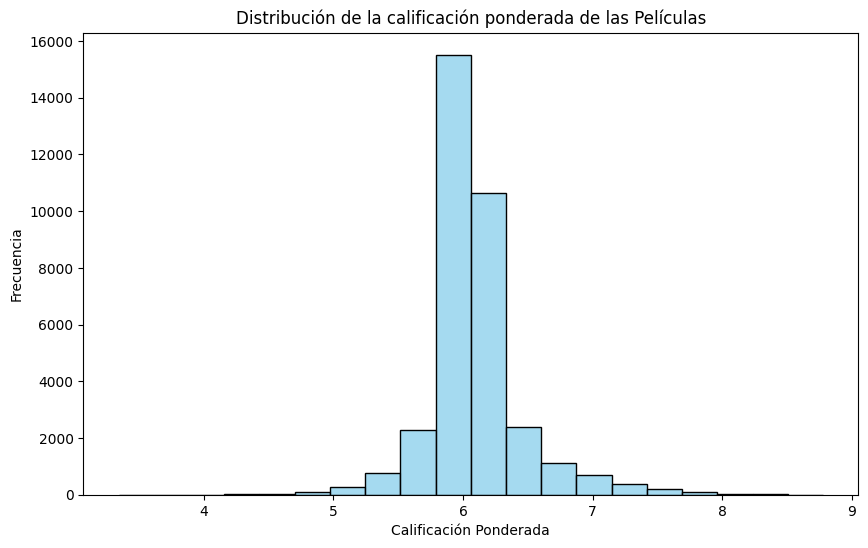

In [2546]:
# Crear el plot para ver la distribución de las calificaciones ponderadas
plt.figure(figsize=(10, 6))
sns.histplot(df_movies_filtered['weighted_rating'], bins=20, color='skyblue')

# Añadir títulos y etiquetas
plt.title('Distribución de la calificación ponderada de las Películas')
plt.xlabel('Calificación Ponderada')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

Al tener la calificación ponderada, es posible eliminar las columnas vote_average y vote_count

In [2547]:
df_movies_filtered.drop(columns=['vote_average', 'vote_count'], inplace=True)

### Relación Género - Popularidad
Se quiere analizar cuales géneros tienen mayor popularidad dentro del dataset

In [2548]:
df_final = (
    df_movies_filtered[['genres', 'popularity']]
    .explode('genres')  # Descomponer la columna de listas
    .groupby('genres', as_index=False)['popularity'].mean()  # Agrupar por el id de género y sumar popularidades
    .merge(df_genres[['id', 'name']], left_on='genres', right_on='id')  # Hacer el merge con géneros
    [['name', 'popularity']]  # Seleccionar las columnas finales
    .sort_values(by='popularity', ascending=False)  # Ordenar por popularidad de forma descendente
    .reset_index(drop=True)  # Restablecer el índice
)

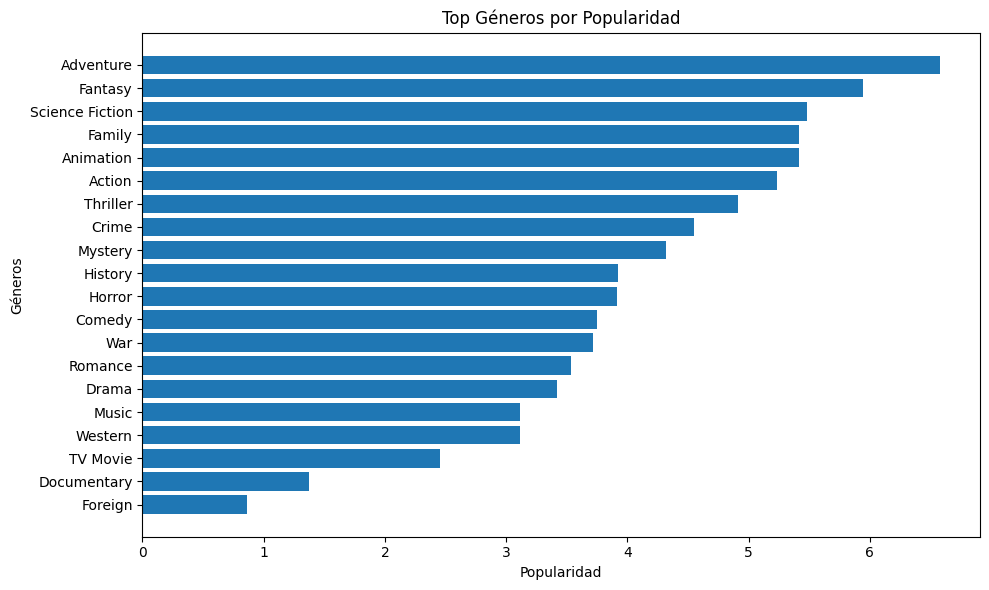

In [2549]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_final['name'], df_final['popularity'])
plt.xlabel('Popularidad')
plt.ylabel('Géneros')
plt.title('Top Géneros por Popularidad')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Relación Productora - Popularidad
Se quiere analizar cuales compañías productoras tienen mayor popularidad dentro del dataset

In [2550]:
df_final = (
    df_movies_filtered[['production_companies', 'popularity']]
    .explode('production_companies')  # Descomponer la columna de listas
    .groupby('production_companies', as_index=False)['popularity'].sum()  # Agrupar por el id de productora y sumar popularidades
    .merge(df_prodcompanies[['id', 'name']], left_on='production_companies', right_on='id')  # Hacer el merge con nombres de productoras
    [['name', 'popularity']]  # Seleccionar las columnas finales
    .sort_values(by='popularity', ascending=False)  # Ordenar por popularidad de forma descendente
    .reset_index(drop=True)  # Restablecer el índice
)

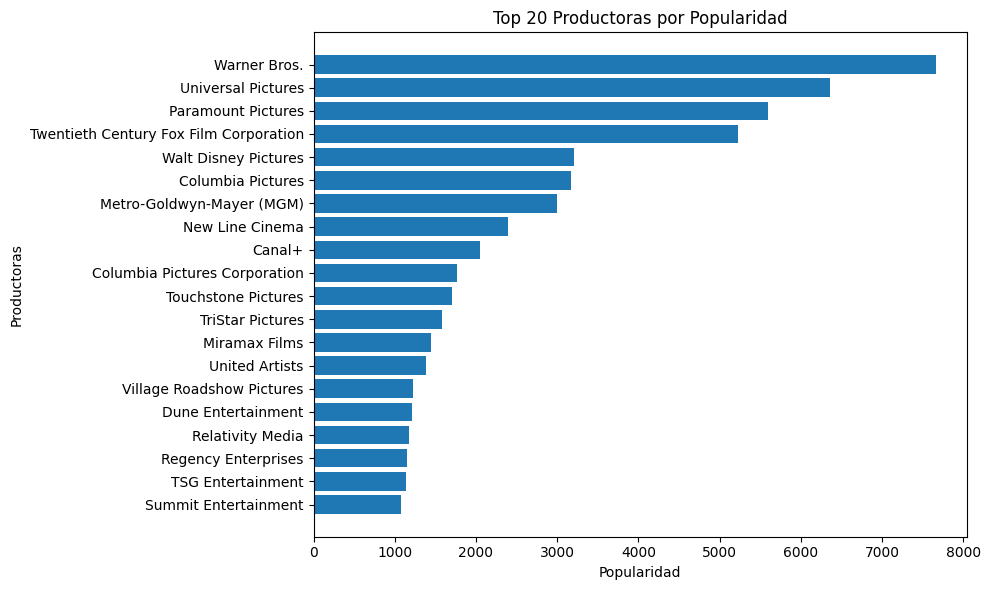

In [2551]:
# Seleccionar las primeras 20 productoras según popularidad
top_20 = df_final.head(20)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_20['name'], top_20['popularity'])
plt.xlabel('Popularidad')
plt.ylabel('Productoras')
plt.title('Top 20 Productoras por Popularidad')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Relación Actor - Película
Se analizará la tabla de actores a partir de su participación en distintas películas

In [2552]:
df_final_actor = (
    df_movies_filtered[['id', 'popularity']]
    .merge(
        df_cast[['idPelicula', 'nombre', 'ordenReparto', 'Hombre']], 
        left_on='id', 
        right_on='idPelicula'
    )
    # Filtrar las filas donde 'ordenReparto' esté entre 0 y 3 y 'Hombre' sea True
    .query('0 <= ordenReparto <= 3 and Hombre == True')
    [['nombre', 'popularity']]
    .groupby('nombre', as_index=False)['popularity'].sum()
    .sort_values(by='popularity', ascending=False)
    .reset_index(drop=True)
)

### Relación Actriz - Película
Se analizará la tabla de actrices a partir de su participación en distintas películas

In [2553]:
df_final_actriz = (
    df_movies_filtered[['id', 'popularity']]
    .merge(
        df_cast[['idPelicula', 'nombre', 'ordenReparto', 'Mujer']], 
        left_on='id', 
        right_on='idPelicula'
    )
    # Filtrar las filas donde 'ordenReparto' esté entre 0 y 5 y 'Hombre' sea True
    .query('0 <= ordenReparto <= 2 and Mujer == True')
    [['nombre', 'popularity']]
    .groupby('nombre', as_index=False)['popularity'].sum()
    .sort_values(by='popularity', ascending=False)
    .reset_index(drop=True)
)

### Relación Director(a) - Película
Se analizará la tabla de directores(as) a partir de su participación en distintas películas

In [2554]:
df_final_direccion = (
    df_movies_filtered[['id', 'popularity']]
    .merge(
        df_crew[['idPelicula', 'nombre', 'cargo']], 
        left_on='id', 
        right_on='idPelicula'
    )
    # Filtrar las filas donde 'cargo' sea 'Director'
    .query('cargo == "Director"')
    [['nombre', 'popularity']]
    .groupby('nombre', as_index=False)['popularity'].sum()
    .sort_values(by='popularity', ascending=False)
    .reset_index(drop=True)
)

Con el fin de reducir el tamaño del dataset, se filtrarán los datos con el top 50 de estas variables

In [2555]:
# Dataframes de top 100
top_100_actors = df_final_actor.head(75)
top_100_actrices = df_final_actriz.head(75)
top_100_direction = df_final_direccion.head(60)


# Filtrar los idPelicula de los actores en df_cast donde 'ordenReparto' esté entre 0 y 2
id_peliculas_actor = df_cast[
    (df_cast['nombre'].isin(top_100_actors['nombre'])) & (df_cast['ordenReparto'].between(0, 2))
]['idPelicula'].unique()

# Filtrar los idPelicula de las actrices en df_cast
id_peliculas_actriz = df_cast[
    (df_cast['nombre'].isin(top_100_actrices['nombre'])) & (df_cast['ordenReparto'].between(0, 2))
]['idPelicula'].unique()

# Filtrar los idPelicula de los directores en df_crew donde el 'cargo' sea 'Director'
id_peliculas_director = df_crew[
    (df_crew['nombre'].isin(top_100_direction['nombre'])) & (df_crew['cargo'] == 'Director')
]['idPelicula'].unique()

# Combinar todos los idPelicula en una lista única (sin duplicados)
id_peliculas_a_filtrar = set(id_peliculas_actor) | set(id_peliculas_actriz) | set(id_peliculas_director)

# Filtrar df_movies_filtered basado en los idPelicula combinados
df_filtrado = df_movies_filtered[
    df_movies_filtered['id'].isin(id_peliculas_a_filtrar)
]

# Verificar el resultado
df_filtrado.head()

,id,title,genres,overview,runtime,production_companies,spoken_languages,production_countries,popularity,release_year,weighted_rating
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],[English],[US],21.946943,1995,7.68
1,8844,Jumanji,"[12, 14, 10751]",When siblings Judy and Peter discover an encha...,104.0,"[559, 2550, 10201]","[English, Other_Languages]",[US],17.015539,1995,6.87
4,11862,Father of the Bride Part II,[35],Just when George Banks has recovered from his ...,106.0,"[5842, 9195]",[English],[US],8.387519,1995,5.80
5,949,Heat,"[28, 80, 18, 53]","Obsessive master thief, Neil McCauley leads a ...",170.0,"[508, 675, 6194]","[English, Other_Languages]",[US],17.924927,1995,7.63
6,11860,Sabrina,"[35, 10749]",An ugly duckling having undergone a remarkable...,127.0,"[4, 258, 932, 5842, 14941, 55873, 58079]","[Other_Languages, English]","[Other_Countries, US]",6.677277,1995,6.14


In [2556]:
df_movies_filtered.shape

(34607, 11)

In [2557]:
df_filtrado.shape

(4569, 11)

### Análisis de la columna Overview
Análisis de características de la descripción de las películas

In [2558]:
# Eliminar nulos
df_filtrado.dropna(subset=['overview'], inplace=True)

In [2559]:
df_filtrado.head()

,id,title,genres,overview,runtime,production_companies,spoken_languages,production_countries,popularity,release_year,weighted_rating
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],[English],[US],21.946943,1995,7.68
1,8844,Jumanji,"[12, 14, 10751]",When siblings Judy and Peter discover an encha...,104.0,"[559, 2550, 10201]","[English, Other_Languages]",[US],17.015539,1995,6.87
4,11862,Father of the Bride Part II,[35],Just when George Banks has recovered from his ...,106.0,"[5842, 9195]",[English],[US],8.387519,1995,5.80
5,949,Heat,"[28, 80, 18, 53]","Obsessive master thief, Neil McCauley leads a ...",170.0,"[508, 675, 6194]","[English, Other_Languages]",[US],17.924927,1995,7.63
6,11860,Sabrina,"[35, 10749]",An ugly duckling having undergone a remarkable...,127.0,"[4, 258, 932, 5842, 14941, 55873, 58079]","[Other_Languages, English]","[Other_Countries, US]",6.677277,1995,6.14


### Nube de palabras
Se crear una nube de palabras con el objetivo de identificar palabras clave en la columna 'overview'

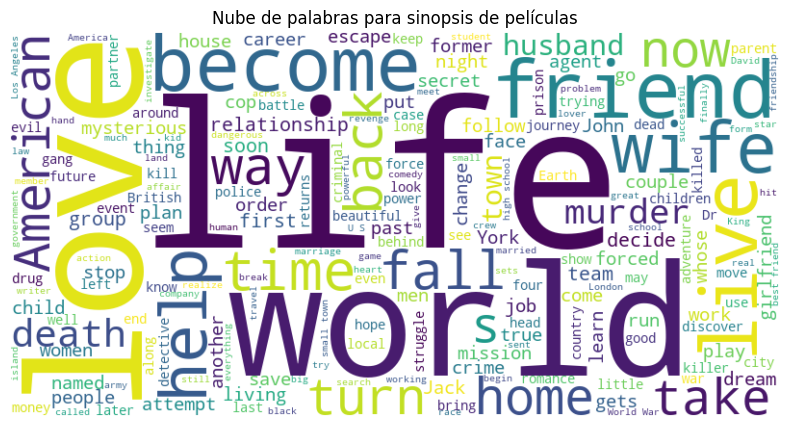

In [2560]:
# Rellenar los valores nulos con una cadena vacía
df_filtrado['overview'] = df_filtrado['overview'].fillna('')

# Definir las stopwords (palabras que queremos excluir)
stopwords = set(STOPWORDS)
stopwords.update([
    "the", "a", "an", "and", "or", "but", "so", "of", "in", "on", "with", "by", "for", "from", "at", "to", "it", "its", "this", "that", "is", "are", "was", "were", 
    "be", "been", "being",
    "have", "has", "had", "i", "you", "he", "she", "we", "they", "his", "her", "their", "there", "them", "then", "when", "where", "what", "who", "which", "why", 
    "how", "just", "about",
    "into", "like", "out", "over", "under", "before", "after", "as", "all", "one", "two", "three", "more", "most", "many", "few", 
    "movie", "film", "films", "story", "plot", "character", "characters", "director", "actors", "role", "scene", "scenes", "based", "villain", "sequel", "prequel", 
    "series", "set", "takes",
    "place", "stars", "produced", "produces", "production", "released", "release", "year", "years", 
    "month", "months", "day", "days", "part", "parts",
    "young", "old", "man", "woman", "boy", "girl", "family", "father", "mother", "son", "daughter", "brother", "sister", "find", 
    "discovers", "fight", "against", "away", "new", "return", "facing", "must", "will", 
    "can", "tries", "ends", "begins", "helps",
    "starts", "goes", "comes", "leads", "takes", "finds", "discovers", "faces", "tries", "leaves", "meets", "begins", "ends", "find", "fights", "wants", "needs", 
    "helps", "works", 
    "together", "make", "makes", "tells", "asks"
])

# Unir todas las sinopsis en un solo string
text = " ".join(overview for overview in df_filtrado['overview'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nube de palabras para sinopsis de películas')
plt.show()

## Correlaciones de variables numéricas
Análisis de la relación existente entre variables numéricas dentro del dataset

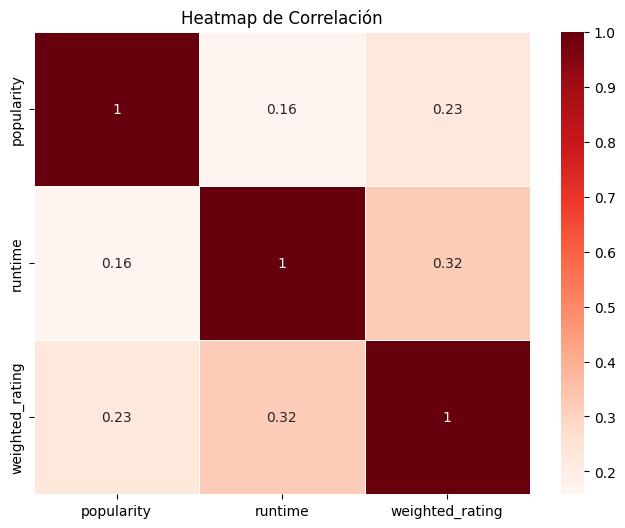

In [2561]:
correlation_matrix = df_filtrado[['popularity','runtime','weighted_rating']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=0.5)
plt.title("Heatmap de Correlación")
plt.show()

Existe una relación positiva entre la popularidad y el ponderado de rating, es decir, las películas con mejor valoración son las más populares

Vista previa del dataframe final

In [2562]:
df_filtrado.head()

,id,title,genres,overview,runtime,production_companies,spoken_languages,production_countries,popularity,release_year,weighted_rating
0,862,Toy Story,"[16, 35, 10751]","Led by Woody, Andy's toys live happily in his ...",81.0,[3],[English],[US],21.946943,1995,7.68
1,8844,Jumanji,"[12, 14, 10751]",When siblings Judy and Peter discover an encha...,104.0,"[559, 2550, 10201]","[English, Other_Languages]",[US],17.015539,1995,6.87
4,11862,Father of the Bride Part II,[35],Just when George Banks has recovered from his ...,106.0,"[5842, 9195]",[English],[US],8.387519,1995,5.80
5,949,Heat,"[28, 80, 18, 53]","Obsessive master thief, Neil McCauley leads a ...",170.0,"[508, 675, 6194]","[English, Other_Languages]",[US],17.924927,1995,7.63
6,11860,Sabrina,"[35, 10749]",An ugly duckling having undergone a remarkable...,127.0,"[4, 258, 932, 5842, 14941, 55873, 58079]","[Other_Languages, English]","[Other_Countries, US]",6.677277,1995,6.14


Exportar dataframe para preprocesamiento

In [2563]:
df_filtrado.to_parquet('../Datasets/Datasets_Limpios/Parquet/movies_tomodel.parquet')